# Machine Learning

In [1]:
%pylab inline
import pandas as pd
import os
import numpy as np
from ggplot import *
from tabulate import tabulate
import multiprocessing as mp

Populating the interactive namespace from numpy and matplotlib


## 1. Data Manipulation and Preparation

In [2]:
os.chdir(r'C:\Users\Tobias\OneDrive\Bachelor Thesis\Empirical Look at Software Patents\test')

In [3]:
dfluk = pd.read_excel('class_lukas.xlsx') ### Classifications by Lukas
dfbh = pd.read_stata('BH2007.dta') ### Classifications by Bessen & Hunt (2007)

##### Preparation Lukas

In [4]:
dfluk['software_man_class'] = ((dfluk.Classification == 1) & (dfluk.Cognitive == 1))

dfluk = dfluk[['Patent number', 'Highly uncertain', 'software_man_class']]

dfluk.columns = ['patentnr', 'highly_uncertain', 'software_man_class']

dfluk['test_sample'] = False

d = {0: False, 1: True, 2: True}
dfluk.highly_uncertain = dfluk.highly_uncertain.map(d)

##### Preparation BH2007 Classification

In [5]:
dfbh = dfbh[['patentnr', 'software_man_class']]
dfbh['test_sample'] = True
dfbh['highly_uncertain'] = False

dfbh.patentnr = dfbh.patentnr.astype(np.int64)

d = {0: False, 1: True, 2: True}
dfbh.software_man_class = dfbh.software_man_class.map(d)

##### Merging both classications

In [6]:
prev_res = pd.concat([dfluk, dfbh], axis=0, ignore_index=True)

##### Preparation Patsearch Results

In [11]:
dfpat = pd.read_csv('patsearch_results_1976-2015_BH2007.csv', usecols=['patentnr', 'classnr', 'week', 'year'], index_col=0)
dfpat = dfpat.reset_index()

C:\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


##### Merging Classification and Patsearch Results

In [12]:
result = pd.merge(prev_res, dfpat, how='left', on='patentnr')
result = result.dropna(axis=0).reset_index()

In [13]:
result.to_pickle('classified_sample.pickle')

##### Crawling text data for Classification.csv and create the Corpora

In [15]:
import requests
from bs4 import BeautifulSoup

def parse_pattext(patentnr):

    patentnr = str(patentnr)

    patent = 'US' + patentnr
    url = 'https://www.google.de/patents/' + patent
    result = requests.get(url)
    htmldoc = result.text
    soup = BeautifulSoup(htmldoc, 'html.parser')


    abstract = soup.find(attrs={'class': 'abstract'}).text
    description = soup.find(attrs={'class': 'description'}).text

    text = abstract + description
    return text

In [16]:
######## Writing texts in Pandas DataFrame
import pandas as pd

dfsam = pd.read_pickle('classified_sample.pickle')
dfsam['label'] = dfsam.software_man_class.map({True: 'software', False: 'nonsoftware'})
dfsam['text'] = [parse_pattext(k) for k in dfsam.patentnr]
dfsam.to_pickle('classified_sample_wtext.pickle')

##### Splitting DataFrame into Training and Test Dataset

In [ ]:
df = read_pickle('classified_sample_wtext.pickle')
dftrain = (df.test_sample == False)
dftrain.reset_index.to_pickle('train_sample.pickle')
dftest = (df.test_sample == True)
dftest.reset_index().to_pickle('test_sample.pickle')

## 3. Text Processing

##### Open Corpus

In [3]:
dftrain = pd.read_pickle('train_sample.pickle')
dftrain = dftrain[['label', 'text']]
dftest = pd.read_pickle('test_sample.pickle')
dftest = dftest[['label', 'text']]

##### Code which is shown in detail and later replaced by pipeline

In [4]:
# ### Tokenizing
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()

# X_train_counts = count_vect.fit_transform(dftrain.text.values)
# print(X_train_counts.shape)

# ### From occurences to frequencies (tf-idf)
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()

# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# print(X_train_tfidf.shape)

# ### Training a classifier
# ######## Specifying target (or label)
# target = dftrain.label.values

# from sklearn.naive_bayes import MultinomialNB

# clf = MultinomialNB().fit(X_train_tfidf, target)

##### Building a pipeline

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# MultinomialNaiveBayes works only with integers
text_clf = Pipeline([
        ('vect', CountVectorizer()),
#        ('tfidf', TfidfTransformer(use_idf=False)),
        ('clf', MultinomialNB()),
                    ])

##### Training a classifier

In [5]:
text_clf = text_clf.fit(dftrain.text.values, dftrain.label.values)

##### Evaluation of the performance on the test set

In [6]:
import numpy as np

predicted = text_clf.predict(dftest.text.values)

from sklearn import metrics
print(metrics.classification_report(dftest.label.values, predicted, target_names=['nonsoftware', 'software']))
print(metrics.confusion_matrix(dftest.label.values, predicted))

             precision    recall  f1-score   support

nonsoftware       0.97      0.83      0.89       345
   software       0.43      0.81      0.56        54

avg / total       0.89      0.83      0.85       399

[[286  59]
 [ 10  44]]


##### Using SVM classifier

In [13]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer(use_idf=False)), #works better without tf
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
                    ])
_ = text_clf.fit(dftrain.text.values, dftrain.label.values)
docs_test = dftest.text.values
predicted = text_clf.predict(docs_test)
np.mean(predicted == dftest.label.values)

from sklearn import metrics
print(metrics.classification_report(dftest.label.values, predicted, target_names=['nonsoftware', 'software']))
print(metrics.confusion_matrix(dftest.label.values, predicted))

             precision    recall  f1-score   support

nonsoftware       0.97      0.76      0.85       345
   software       0.35      0.83      0.49        54

avg / total       0.88      0.77      0.80       399

[[261  84]
 [  9  45]]


##### Grid-seaerch for MultinomialNB

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
#              'vect__binary': (True, False),
#              'tfidf__use_idf': (True, False),
#              'clf__alpha': (1e-2, 1e-3),
#              'clf__fit_prior': (True, False),
}

text_clf = Pipeline([('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, scoring='roc_auc')
gs_clf = gs_clf.fit(dftrain.text.values, dftrain.label.values)

best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# MultinomialNaiveBayes works only with integers
text_clf = Pipeline([
        ('vect', CountVectorizer(binary=True, ngram_range=(1,2))),
#        ('tfidf', TfidfTransformer(use_idf=False)),
        ('clf', MultinomialNB(alpha=1e-2, fit_prior=True)),
                    ])

text_clf = text_clf.fit(dftrain.text.values, dftrain.label.values)

docs_test = dftest.text.values
predicted = text_clf.predict(docs_test)

from sklearn import metrics
print(metrics.classification_report(dftest.label.values, predicted, target_names=['nonsoftware', 'software']))
print(metrics.confusion_matrix(dftest.label.values, predicted))

             precision    recall  f1-score   support

nonsoftware       0.89      0.98      0.93       345
   software       0.61      0.20      0.31        54

avg / total       0.85      0.87      0.85       399

[[338   7]
 [ 43  11]]


I'm not really happy with this result, since I think grid search maximized the f-score, but then it improves the result on nonsoftware patents.

##### Grid-search for SVM

In [ ]:
from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

text_clf = Pipeline([('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', n_iter=5, random_state=42)),
                    ])

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, scoring='roc_auc')
gs_clf = gs_clf.fit(dftrain.text.values, dftrain.label.values)

best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Parsing the patents text

In [13]:
import requests
from bs4 import BeautifulSoup

def parse_pattext(patentnr):
    patent = 'US' + patentnr
    url = 'https://www.google.de/patents/' + patent
    result = requests.get(url)
    htmldoc = result.text
    soup = BeautifulSoup(htmldoc, 'html.parser')


    abstract = soup.find(attrs={'class' : 'abstract'}).text
    description = soup.find(attrs={'class' : 'description'}).text
    
    if abstract == None:
        print('No abstract found for ' + patentnr + '!')
        RuntimeError
    elif description == None:
        print('No description found for ' + patentnr + '!')
        RuntimeError
    else:
        try:
            os.mkdir('texts')
        except FileExistsError:
            pass
        with open('texts/' + patentnr + '_abstract.txt', 'wb') as text_file:
            text_file.write(bytes(abstract, 'UTF-8'))
        with open('texts/' + patentnr + '_description.txt', 'wb') as text_file:
            text_file.write(bytes(description, 'UTF-8'))
#array = [abstract, description]
#return array

In [132]:
import pandas as pd
df =  pd.read_csv('BH2007_merged.csv', index_col=0)

In [ ]:
for item in df.patentnr:
    parse_pattext(str(item))

# Comparing BH2007 algorithm with my replication

In [1]:
%pylab inline
import pandas as pd
import os
import numpy as np
from scipy.io import loadmat
from ggplot import *
from tabulate import tabulate
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from skll.metrics import kappa

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir(r'C:\Users\Tobias\OneDrive\Bachelor Thesis\Empirical Look at Software Patents\test')

In [ ]:
df = pd.read_csv('patsearch_results_1976-2015_BH2007.csv', index_col=0)
bh = pd.read_stata('BH2007.dta')

#### Merge datasets and clean 'nan' which are perhaps results of witddrawals and create two versions of the software_man_class due to values equal to 2

In [77]:
result = pd.merge(bh, df, how='left', on='patentnr')
result = result.dropna() # or index specific result = result.drop(result.index[pd.isnull(result).any(1).nonzero()[0])
result['smcw2'] = (result.software_man_class >= 1)
result['smcwo2'] = (result.software_man_class == 1)
result.to_csv('BH2007_merged.csv')

## The algorithms

In [4]:
def algorithm_results(dataset, benchmark, algo):
    result['tp_w2'] = ((result[algo] == True) & (result[benchmark] == True))
    result['fp_w2'] = ((result[algo] == True) & (result[benchmark] == False))
    result['fn_w2'] = ((result[algo] == False) & (result[benchmark] == True))
    result['tn_w2'] = ((result[algo] == False) & (result[benchmark] == False))

    tp_w2 = result.tp_w2.value_counts()[1]
    fp_w2 = result.fp_w2.value_counts()[1]
    fn_w2 = result.fn_w2.value_counts()[1]
    tn_w2 = result.tn_w2.value_counts()[1]

    table = [['Retrieved', tp_w2, fp_w2], ['Not Retrieved', fn_w2, tn_w2]]
    print(tabulate(table, headers=[' ', 'Relevant', 'Not Relevant']))
    print('Power = ' + str(tp_w2/(tp_w2 + fn_w2)))
    print('Accuracy = ' + str(fp_w2/(tp_w2+fp_w2)))
    print('Precision = ' + str(tp_w2/(tp_w2+fp_w2)))
    print('Recall = ' + str(tp_w2/(tp_w2+fn_w2)))

### Replication of BH2007 with their own algorithm-based classification

In [5]:
result = pd.read_csv('BH2007_merged.csv', index_col=0)
algorithm_results(result, 'smcw2', 'software_algo_class')

print(metrics.classification_report(result.smcw2, result.software_algo_class, target_names=['nonsoftware', 'software']))
print(metrics.confusion_matrix(result.smcw2, result.software_algo_class))
print(roc_auc_score(result.smcw2, result.software_algo_class, average='weighted', sample_weight=None))
print(kappa(result.smcw2, result.software_algo_class))

                 Relevant    Not Relevant
-------------  ----------  --------------
Retrieved              42               8
Not Retrieved          12             337
Power = 0.777777777778
Accuracy = 0.16
Precision = 0.84
Recall = 0.777777777778
             precision    recall  f1-score   support

nonsoftware       0.97      0.98      0.97       345
   software       0.84      0.78      0.81        54

avg / total       0.95      0.95      0.95       399

[[337   8]
 [ 12  42]]
0.87729468599
0.77892287234


In [16]:
%%capture
algorithm_results(result, 'smcwo2', 'software_algo_class')

### Replication of BH2007 with my replication of the alogrithm

#### Two outputs which represent the combinations of BH2007 and smcw2 (software_man_class == 2 included) (specification = abstract + body)

In [7]:
algorithm_results(result, 'smcw2', 'BH2007')

print(metrics.classification_report(result.smcw2, result.BH2007, target_names=['nonsoftware', 'software']))
print(metrics.confusion_matrix(result.smcw2, result.BH2007))
print(kappa(result.smcw2, result.BH2007))

                 Relevant    Not Relevant
-------------  ----------  --------------
Retrieved              45              18
Not Retrieved           9             327
Power = 0.833333333333
Accuracy = 0.285714285714
Precision = 0.714285714286
Recall = 0.833333333333
             precision    recall  f1-score   support

nonsoftware       0.97      0.95      0.96       345
   software       0.71      0.83      0.77        54

avg / total       0.94      0.93      0.93       399

[[327  18]
 [  9  45]]
0.729857819905


In [13]:
%%capture
algorithm_results(result, 'smcwo2', 'BH2007');

#### Two outputs which represent the combinations of BH2007_woabs and smcwo2 (software_man_class == 2 excluded) (specification = body)

In [17]:
%%capture
algorithm_results(result, 'smcw2', 'BH2007_woabs')

In [14]:
%%capture
algorithm_results(result, 'smcwo2', 'BH2007_woabs');

### Conclusion
I can replicate their results with their data. But my algorithm provides different results. The fp are lower in contrast to the fn, which are higher. Therefore, my algorithm has lower precision with a higher recall.

Additional facts:
- with twos is the correct specification according two the paper replication.
- with or without abstract makes no difference on that sample for my alogrithm (so I choose with)

## Concepts for algorithm evaluation
At first the need of an algorithm arises, since we are not able to classify the whole amount of patents due to resource constraints.
The evaluation of our algorithm is neccessary to the whole discussion, since we want to be sure whether our method provides the correct information and is reliable. There are several concepts because they consider the structure of information and weight the different kinds of errors.

Terminology: tp = true positive, fn = false negative and other combinations; relevant = identified by classification, retrieved = identified by algorithm

#### Accuracy
Accuracy is the ratio of correctly identified information to the whole amount of information. For Accuracy the $\alpha$ error (fp) is as important as the $\beta$ error (fn) since tp and tn are added up and are not in relation to fp and fn.
\begin{align}
\text{Accuracy} = \frac{tp + tn}{tp + fp + tn + fn}
\end{align}
This measure is especially imprecise if the data is skew. In this case the proportion of software patents to other patents is relatively small. So, an algorithm which does not retrieve a single patent would have an acceptable accuracy, but would make huge mistakes for false negatives (fn).

#### Precision and Recall
Precision and Recall is another concept to evaluate the information provided by an algorithm. Firstly, precision is the ratio of relevant and retrieved information to the amount of retrieved information or the ratio:
\begin{align}
\text{Precision} = \frac{\text{#(relevant items retrieved)}}{\text{#(retrieved items)}} = P(\text{relevant}|\text{retrieved})
\end{align}
Secondly, recall is the ratio of relevant and retrieved information to the amount of relevant information.
\begin{align}
\text{Recall} = \frac{\text{#(relevant items retrieved)}}{\text{#(relevant items)}} = P(\text{retrieved}|\text{relevant})
\end{align}
In conclusion, the concept of precision and recall relates the number of tp to $\alpha$ and $\beta$ errors and returns values for each relation.
\begin{align}
P &= \frac{tp}{tp+fp}\\
R &= \frac{tp}{tp+fn}
\end{align}

It is extremly useful to have two different values given by precision and recall, since you face situations in which one quality is better than the other. For example, web surfers demand from web search engines high precision, since they only want the first ten results to be relevant. In contrast, recall is especially valuable to individual searches on harddisks.
Because you can always achieve a recall value of one by retrieving all documents there is clear trade off between both where recall is non-decreasing and precision normally decreasing in the number retrieved items.

#### F Measure


##### All information is taken from 'An Introduction to Information Retrieval' (p. 191ff)

# Code for Graphs of Software Patent Development

In [14]:
%pylab inline
import pandas as pd
import os
import numpy as np
from scipy.io import loadmat
from ggplot import *
from tabulate import tabulate

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [15]:
os.chdir(r'C:\Users\Tobias\OneDrive\Bachelor Thesis\Empirical Look at Software Patents\test')

In [16]:
df = pd.read_csv('patsearch_results_1976-2015_BH2007.csv', index_col=0, usecols=['patentnr', 'year', 'BH2007'])

In [20]:
df.BH2007.value_counts(1)

False    0.776744
True     0.223256
dtype: float64

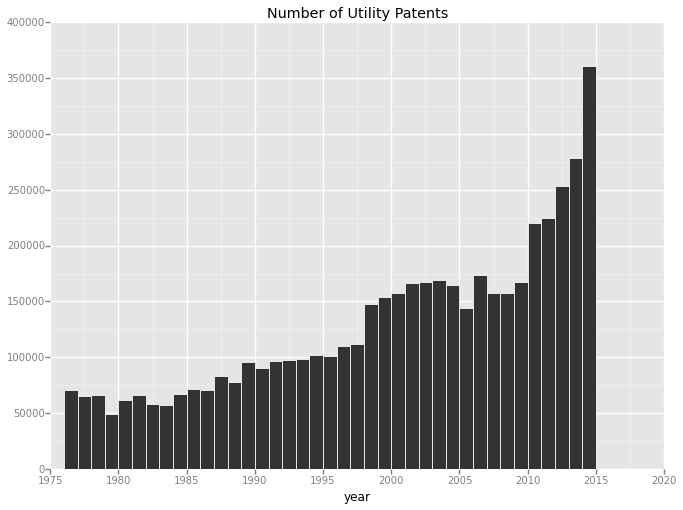

C:\Anaconda3\lib\site-packages\ggplot\geoms\geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


<ggplot: (25539283)>


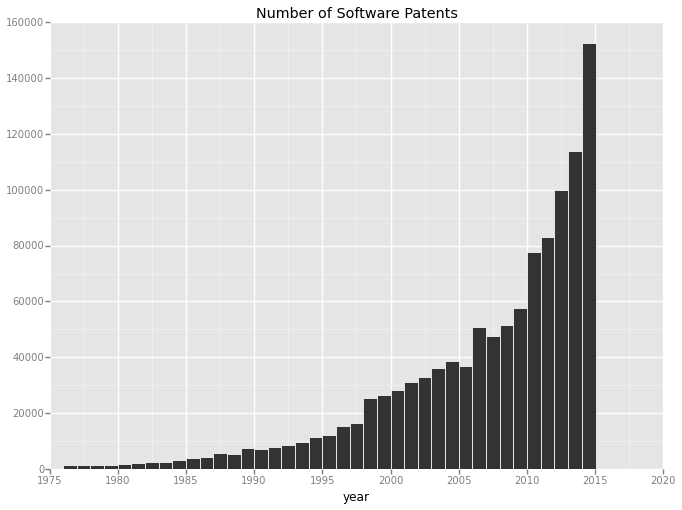

<ggplot: (3060123)>


Saving 11.0 x 8.0 in image.


In [11]:
p1 = ggplot(aes(x='year'), data=(df))
p11 = p1 + geom_histogram(binwidth=1) + ggtitle('Number of Utility Patents')
print(p11)
ggsave('Number of Utility Patents.png', plot=p11)

dfhist = df[df.BH2007]
p2 = ggplot(aes(x='year'), data=(dfhist))
p22 = p2 + geom_histogram(binwidth=1) + ggtitle('Number of Software Patents')
print(p2 + geom_histogram(binwidth=1) + ggtitle('Number of Software Patents'))
ggsave('Number of Software Patents.png', plot=p22)

In [13]:
dfbar = pd.DataFrame({"year":[x for x in range(1976, 2016, 1)], "Percentage of Software Patents":[df.groupby('year')['BH2007'].value_counts(1)[x] for x in range(1,81,2)]})

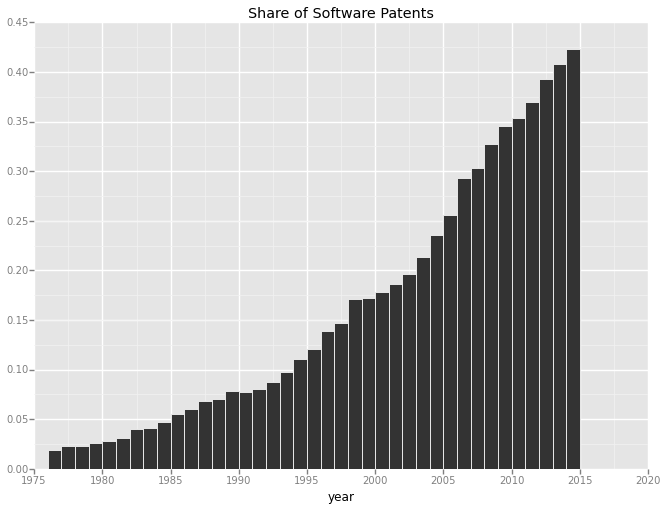

C:\Anaconda3\lib\site-packages\ggplot\geoms\geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


<ggplot: (3920837)>


In [9]:
p33 = ggplot(aes(x="Year", weight="Percentage of Software Patents"), dfbar) + geom_bar(binwidth=1) + ggtitle('Share of Software Patents')
print(p33)
ggsave('Share of Software Patents.png', plot=p33)